In [2]:
!pip install squarify
!pip install keras
!pip install apyori

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import *
from keras.models import Sequential
from keras.layers import *
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.decomposition import TruncatedSVD

Using TensorFlow backend.


In [3]:
orders = pd.read_csv(r"C:\Users\nahum\Documents\GRADSCHOOL\DATA606\InstacartData\orders.csv")

In [5]:
products = pd.read_csv(r"C:\Users\nahum\Documents\GRADSCHOOL\DATA606\InstacartData\products.csv")

In [6]:
aisles = pd.read_csv(r"C:\Users\nahum\Documents\GRADSCHOOL\DATA606\InstacartData\aisles.csv")

In [7]:
departments = pd.read_csv(r"C:\Users\nahum\Documents\GRADSCHOOL\DATA606\InstacartData\departments.csv")

In [8]:
order_products_prior = pd.read_csv(r"C:\Users\nahum\Documents\GRADSCHOOL\DATA606\InstacartData\order_products__prior.csv")

In [9]:
order_products_train = pd.read_csv(r"C:\Users\nahum\Documents\GRADSCHOOL\DATA606\InstacartData\order_products__train.csv")

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [11]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [12]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [13]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
cat = pd.merge(products, departments, how='right', on='department_id')

In [11]:
cat = pd.merge(cat, aisles, how='right', on='aisle_id')

In [12]:
X = pd.merge(order_products_prior, orders, how='left', on='order_id')
#X = pd.merge(order_products_train, X, how='left', on='order_id')

In [13]:
big = pd.merge(X, cat, how='left', on='product_id')
big = big.iloc[0:1000000,]

In [13]:
big.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,pantry,baking ingredients


In [27]:
big.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
department                      0
aisle                           0
dtype: int64

In [14]:
big.replace(np.NaN, 0, inplace=True)

In [15]:
big['days_since_prior_order'] = big['days_since_prior_order'].astype(int)
int_to_cat = ['product_id', 'reordered', 'order_dow',
             'order_hour_of_day', 'aisle_id', 'department_id',
             'days_since_prior_order']

In [16]:
for x in int_to_cat:
    big[x] = big[x].astype('str')

In [17]:
big.drop(['user_id','eval_set'], axis=1, inplace=True)

In [18]:
x1 = (cat.groupby(['department'])
     .count().reset_index())

In [19]:
labels = x1.apply(lambda x: str(x[0]) + '\n (' + str(x[1]) + ')', axis=1)

In [20]:
cmap = matplotlib.cm.Paired
mini = min(x1.product_id)
maxi = max(x1.product_id)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in x1.product_id]

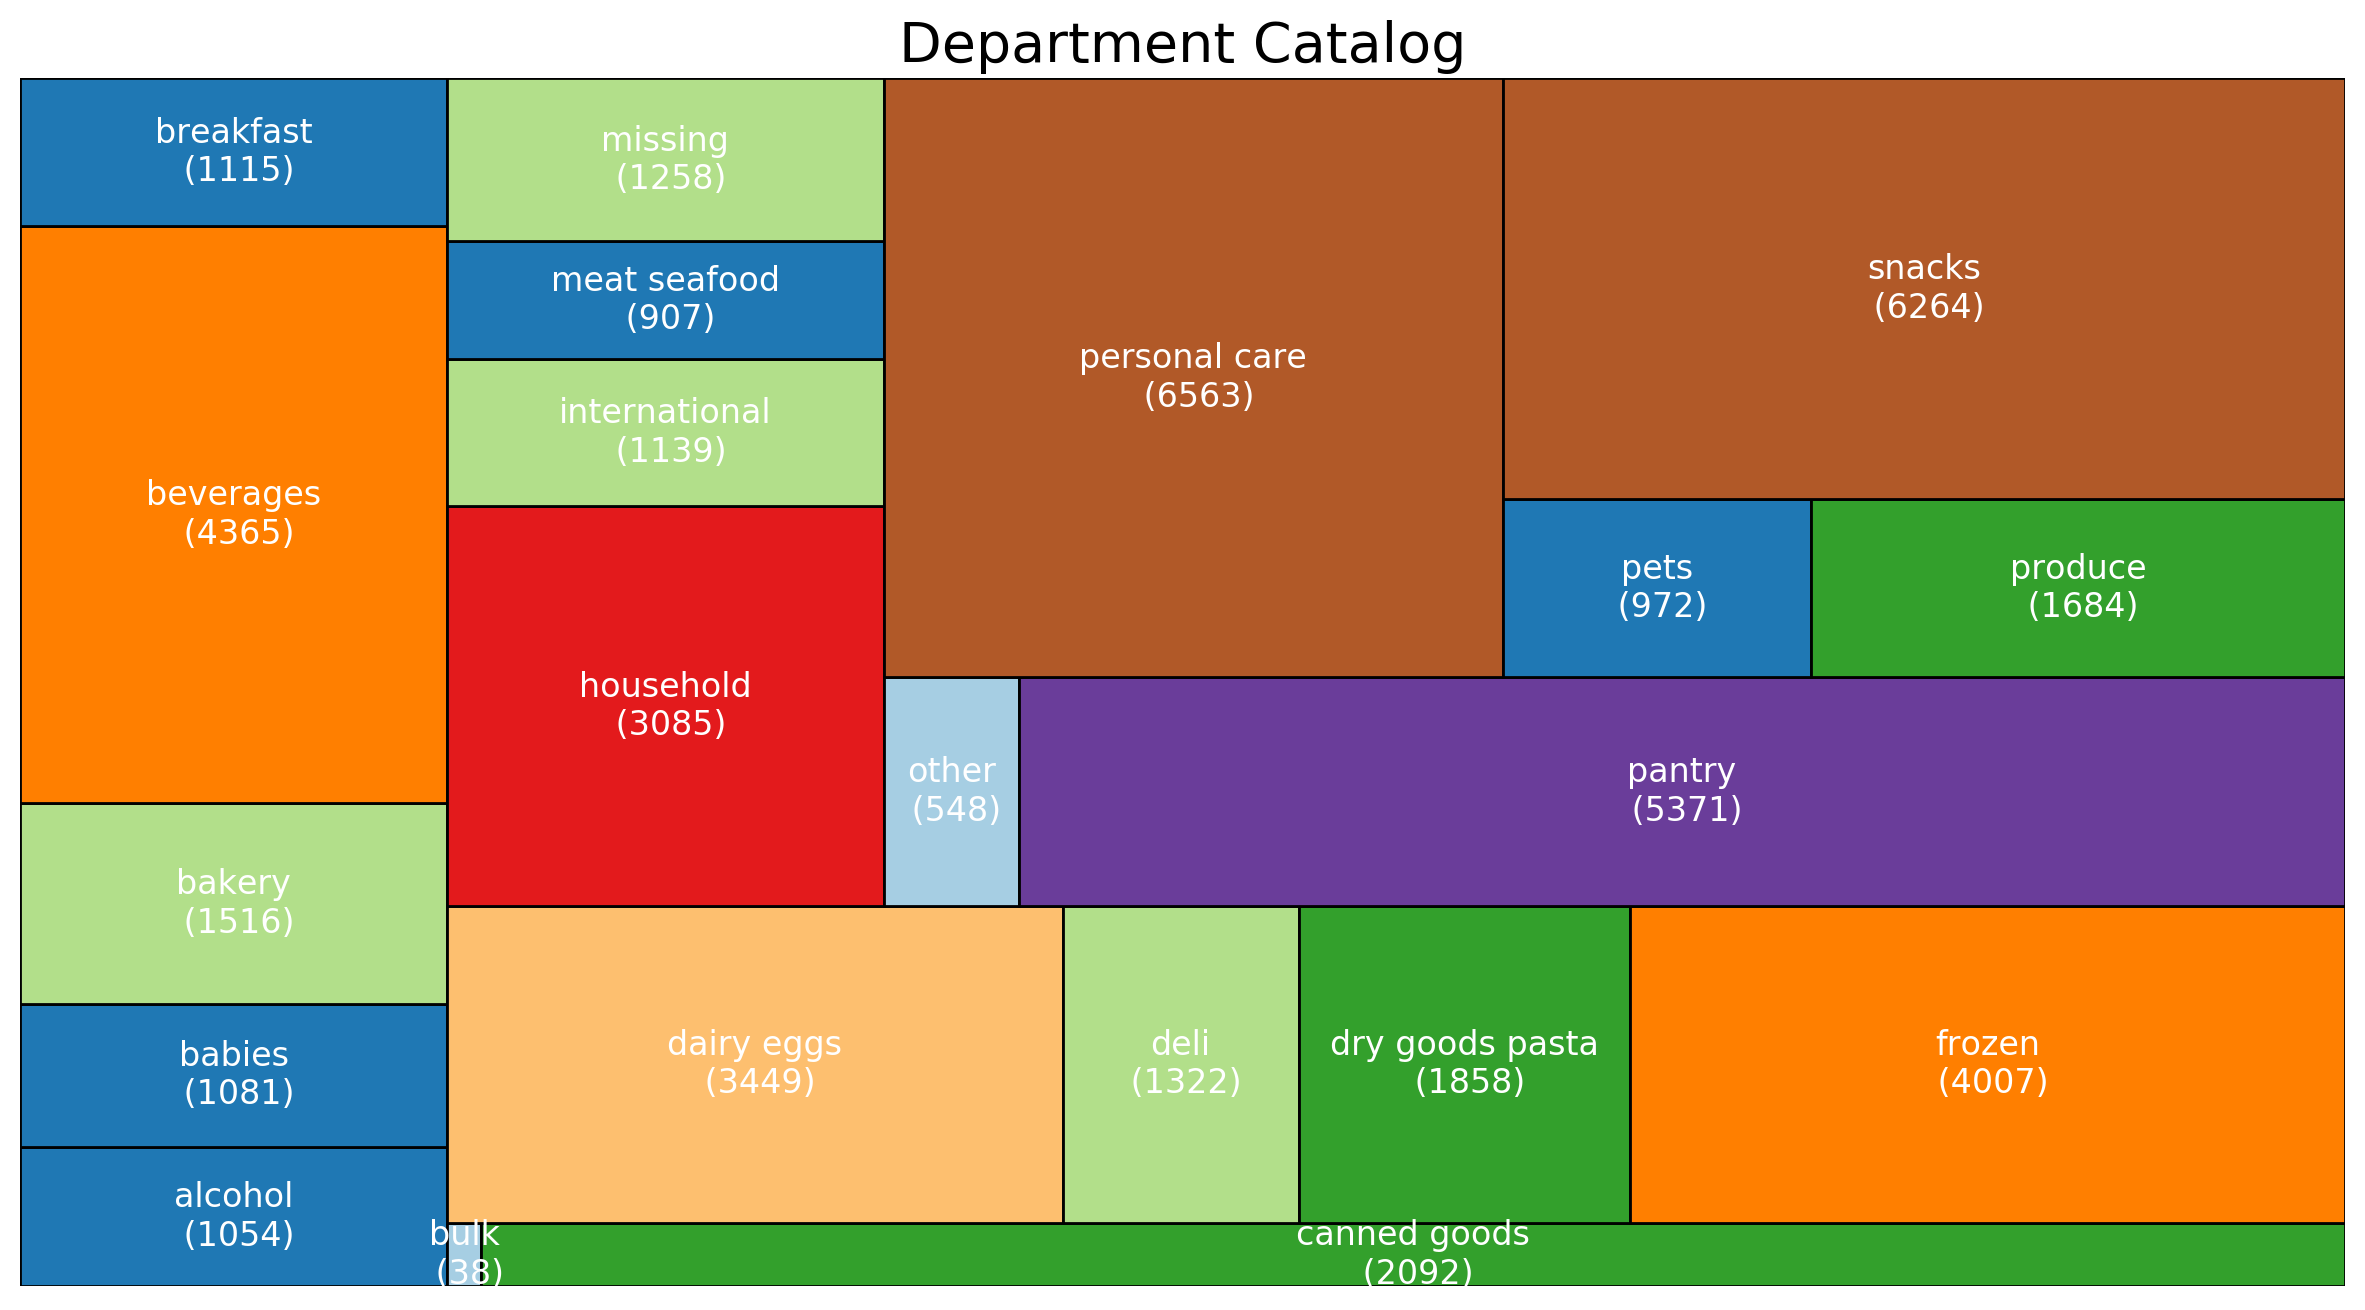

In [21]:
plt.figure(figsize=(15,8), dpi=200)
squarify.plot(label=labels, sizes=x1.product_id, color=colors,
             text_kwargs={'fontsize':'large', 'color':'white'},
             bar_kwargs={'edgecolor':'black', 'linewidth':1})
plt.title('Department Catalog', fontsize=20)
plt.axis('off')
plt.show()

In [58]:
x2 = (cat.groupby(['aisle'])
     .count().reset_index())

In [59]:
labels = x2.apply(lambda x: str(x[0]) + '\n (' + str(x[1]) + ')', axis=1)

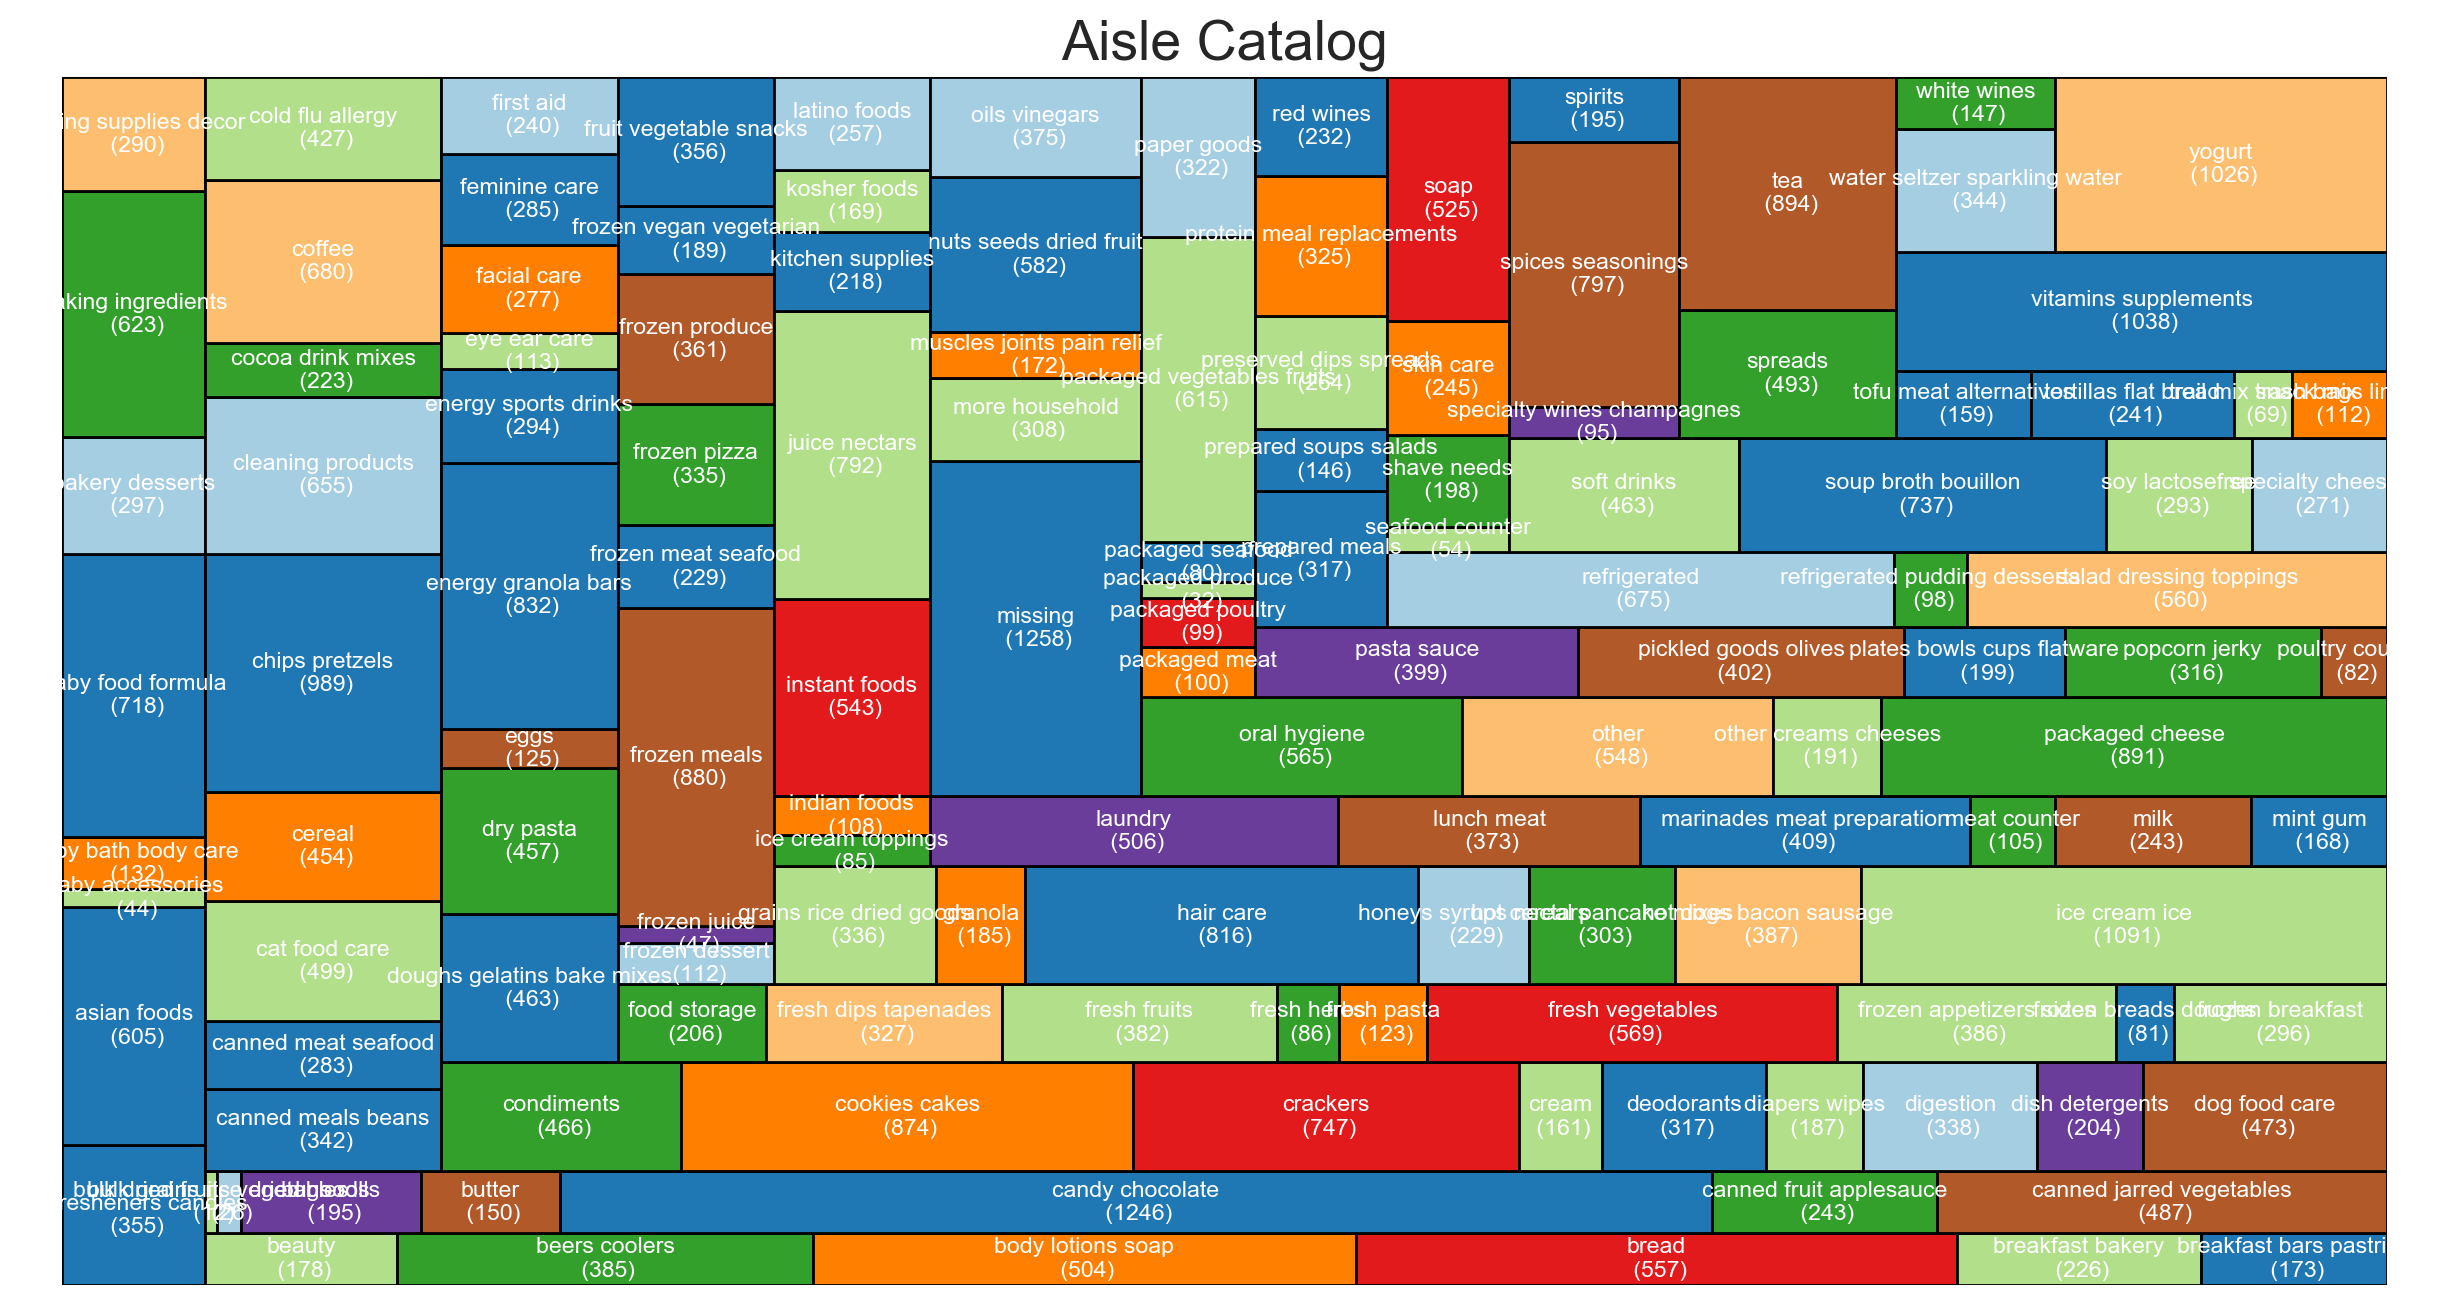

In [60]:
plt.figure(figsize=(15,8), dpi=200)
squarify.plot(label=labels, sizes=x2.product_id, color=colors,
             text_kwargs={'fontsize':'small', 'color':'white'},
             bar_kwargs={'edgecolor':'black', 'linewidth':1})
plt.title('Aisle Catalog', fontsize=20)
plt.axis('off')
plt.show()

In [61]:
x3 = (big.groupby(['department', 'order_hour_of_day'])
     .count().reset_index())

In [62]:
x3 = (x3.loc[:,'department':'order_id']
     .rename(columns={'order_id':'number_of_orders'}))
x3.order_hour_of_day = x3.order_hour_of_day.astype('int')

Text(0, 0.5, 'Number of Purchases')

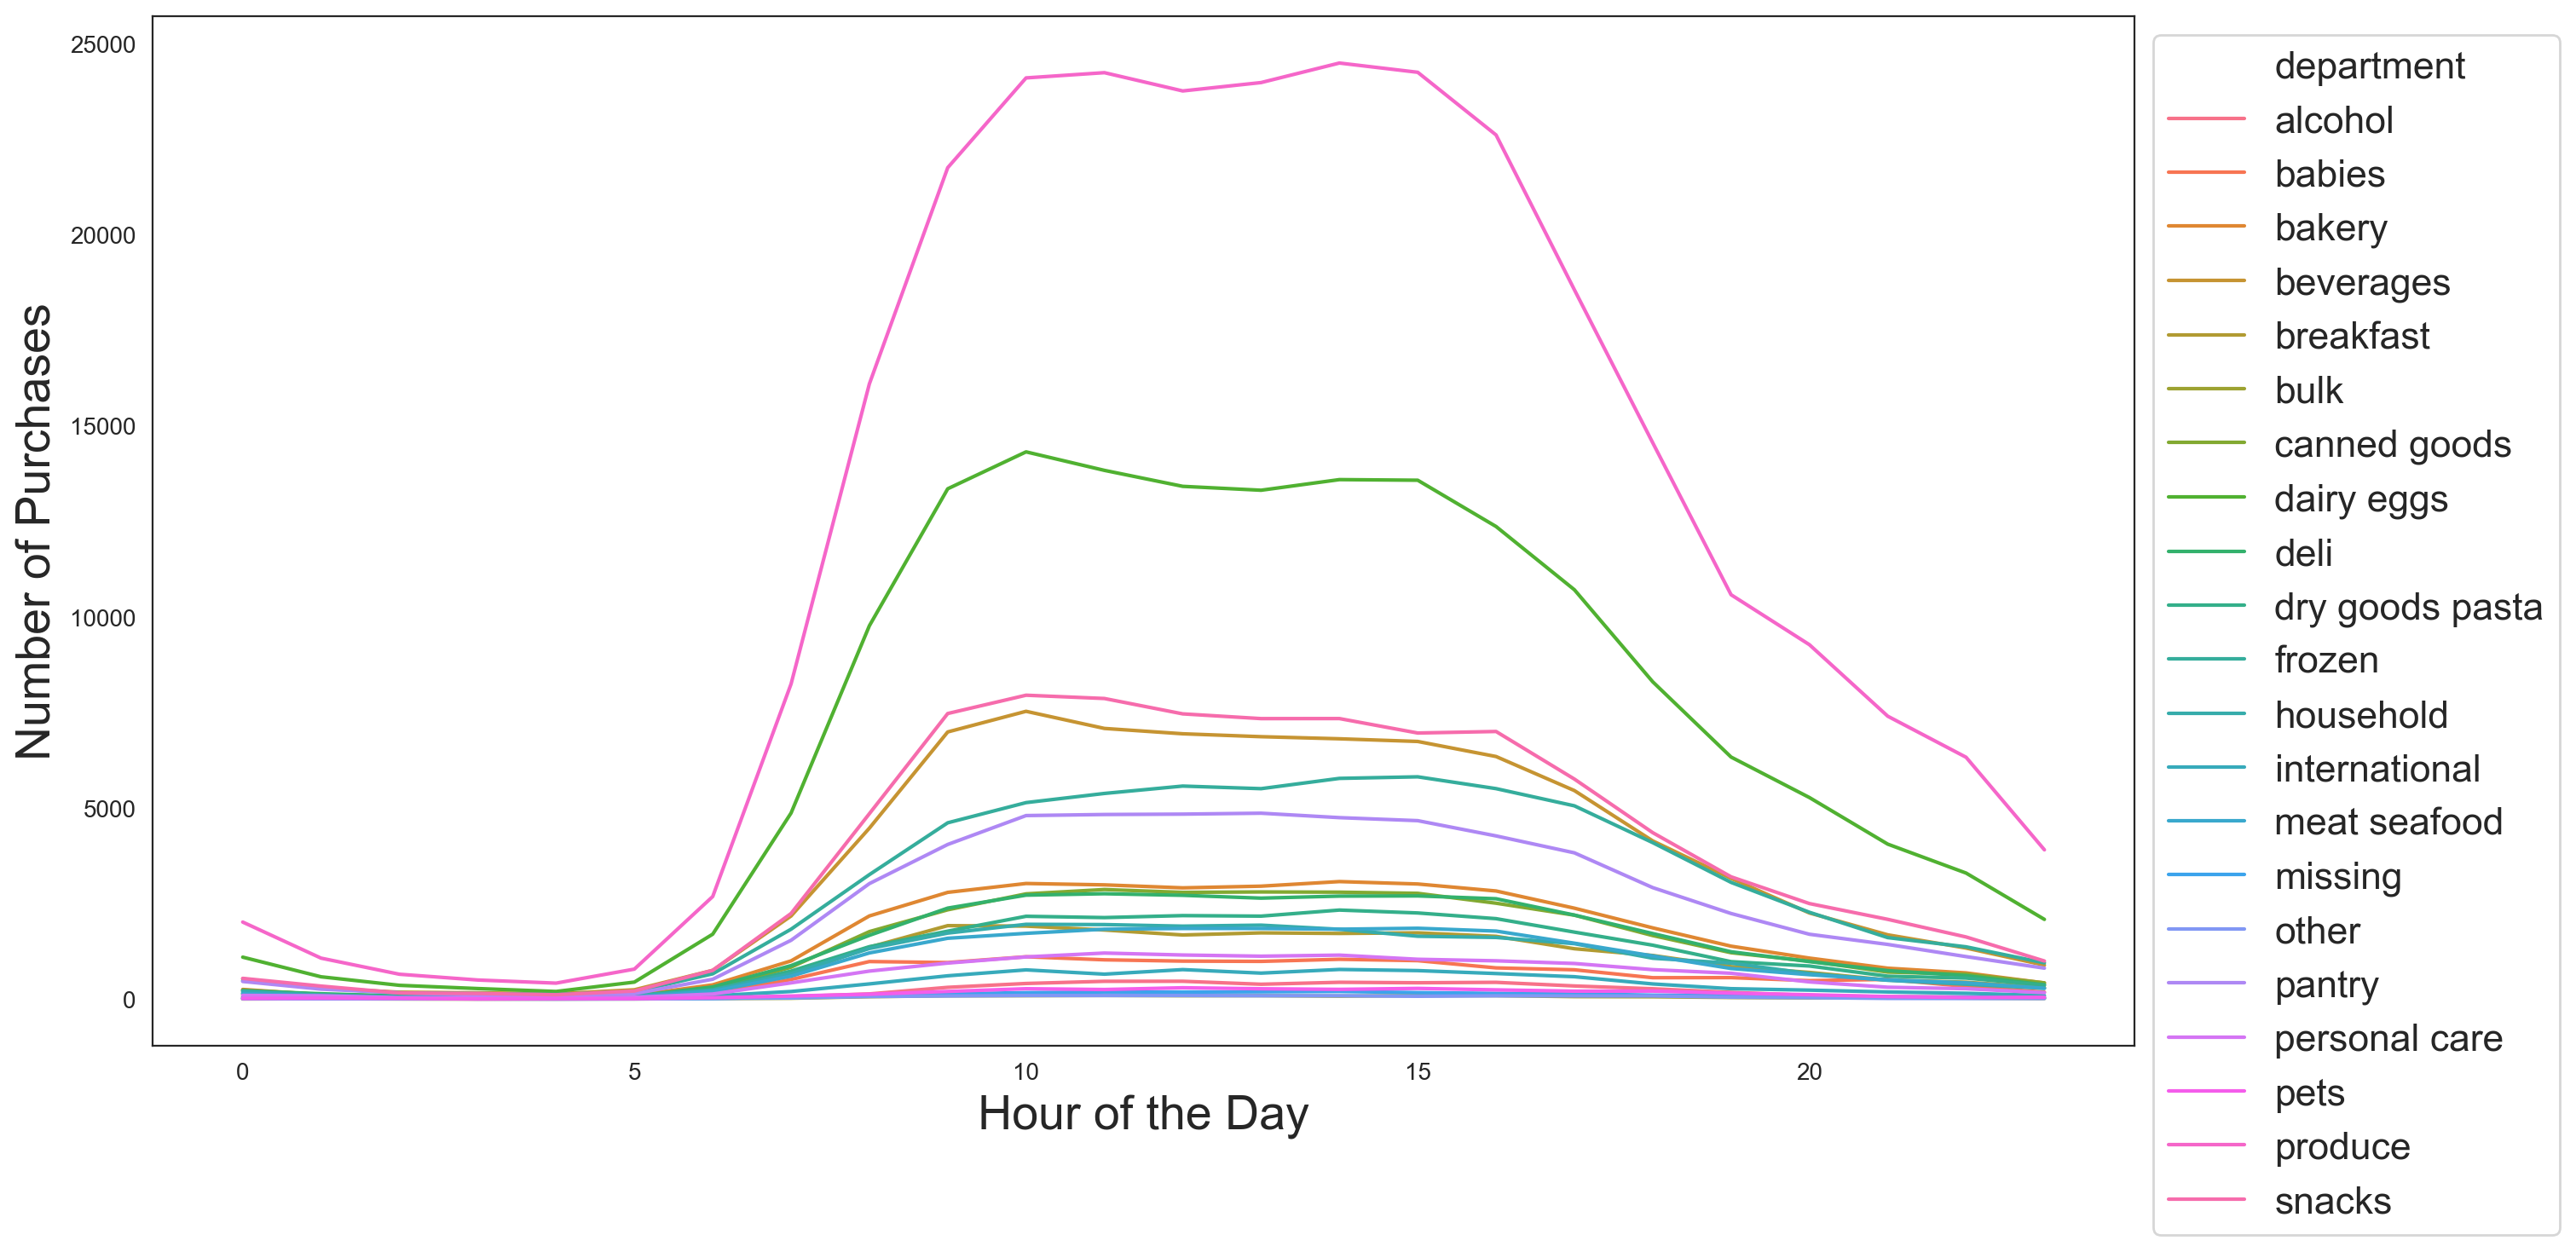

In [63]:
sns.set_style('white')
plt.figure(figsize=(15, 8), dpi=200)
sns.lineplot(x='order_hour_of_day', y='number_of_orders',
            hue='department', data=x3)
plt.legend(bbox_to_anchor=(1,1),loc=2, fontsize=16)
plt.xlabel('Hour of the Day', fontsize=20)
plt.ylabel('Number of Purchases', fontsize=20)

In [1]:
x4 = (big.groupby(['add_to_cart_order', 'department'])
     .count().reset_index())

NameError: name 'big' is not defined

In [65]:
x4 = (x4.loc[:,'add_to_cart_order':'order_id']
     .rename(columns={'order_id':'number_of_orders'}))
x4 = x4[x4.add_to_cart_order <= 5]
x4 = x4[x4.number_of_orders > 2500]

ValueError: Invalid RGBA argument: masked

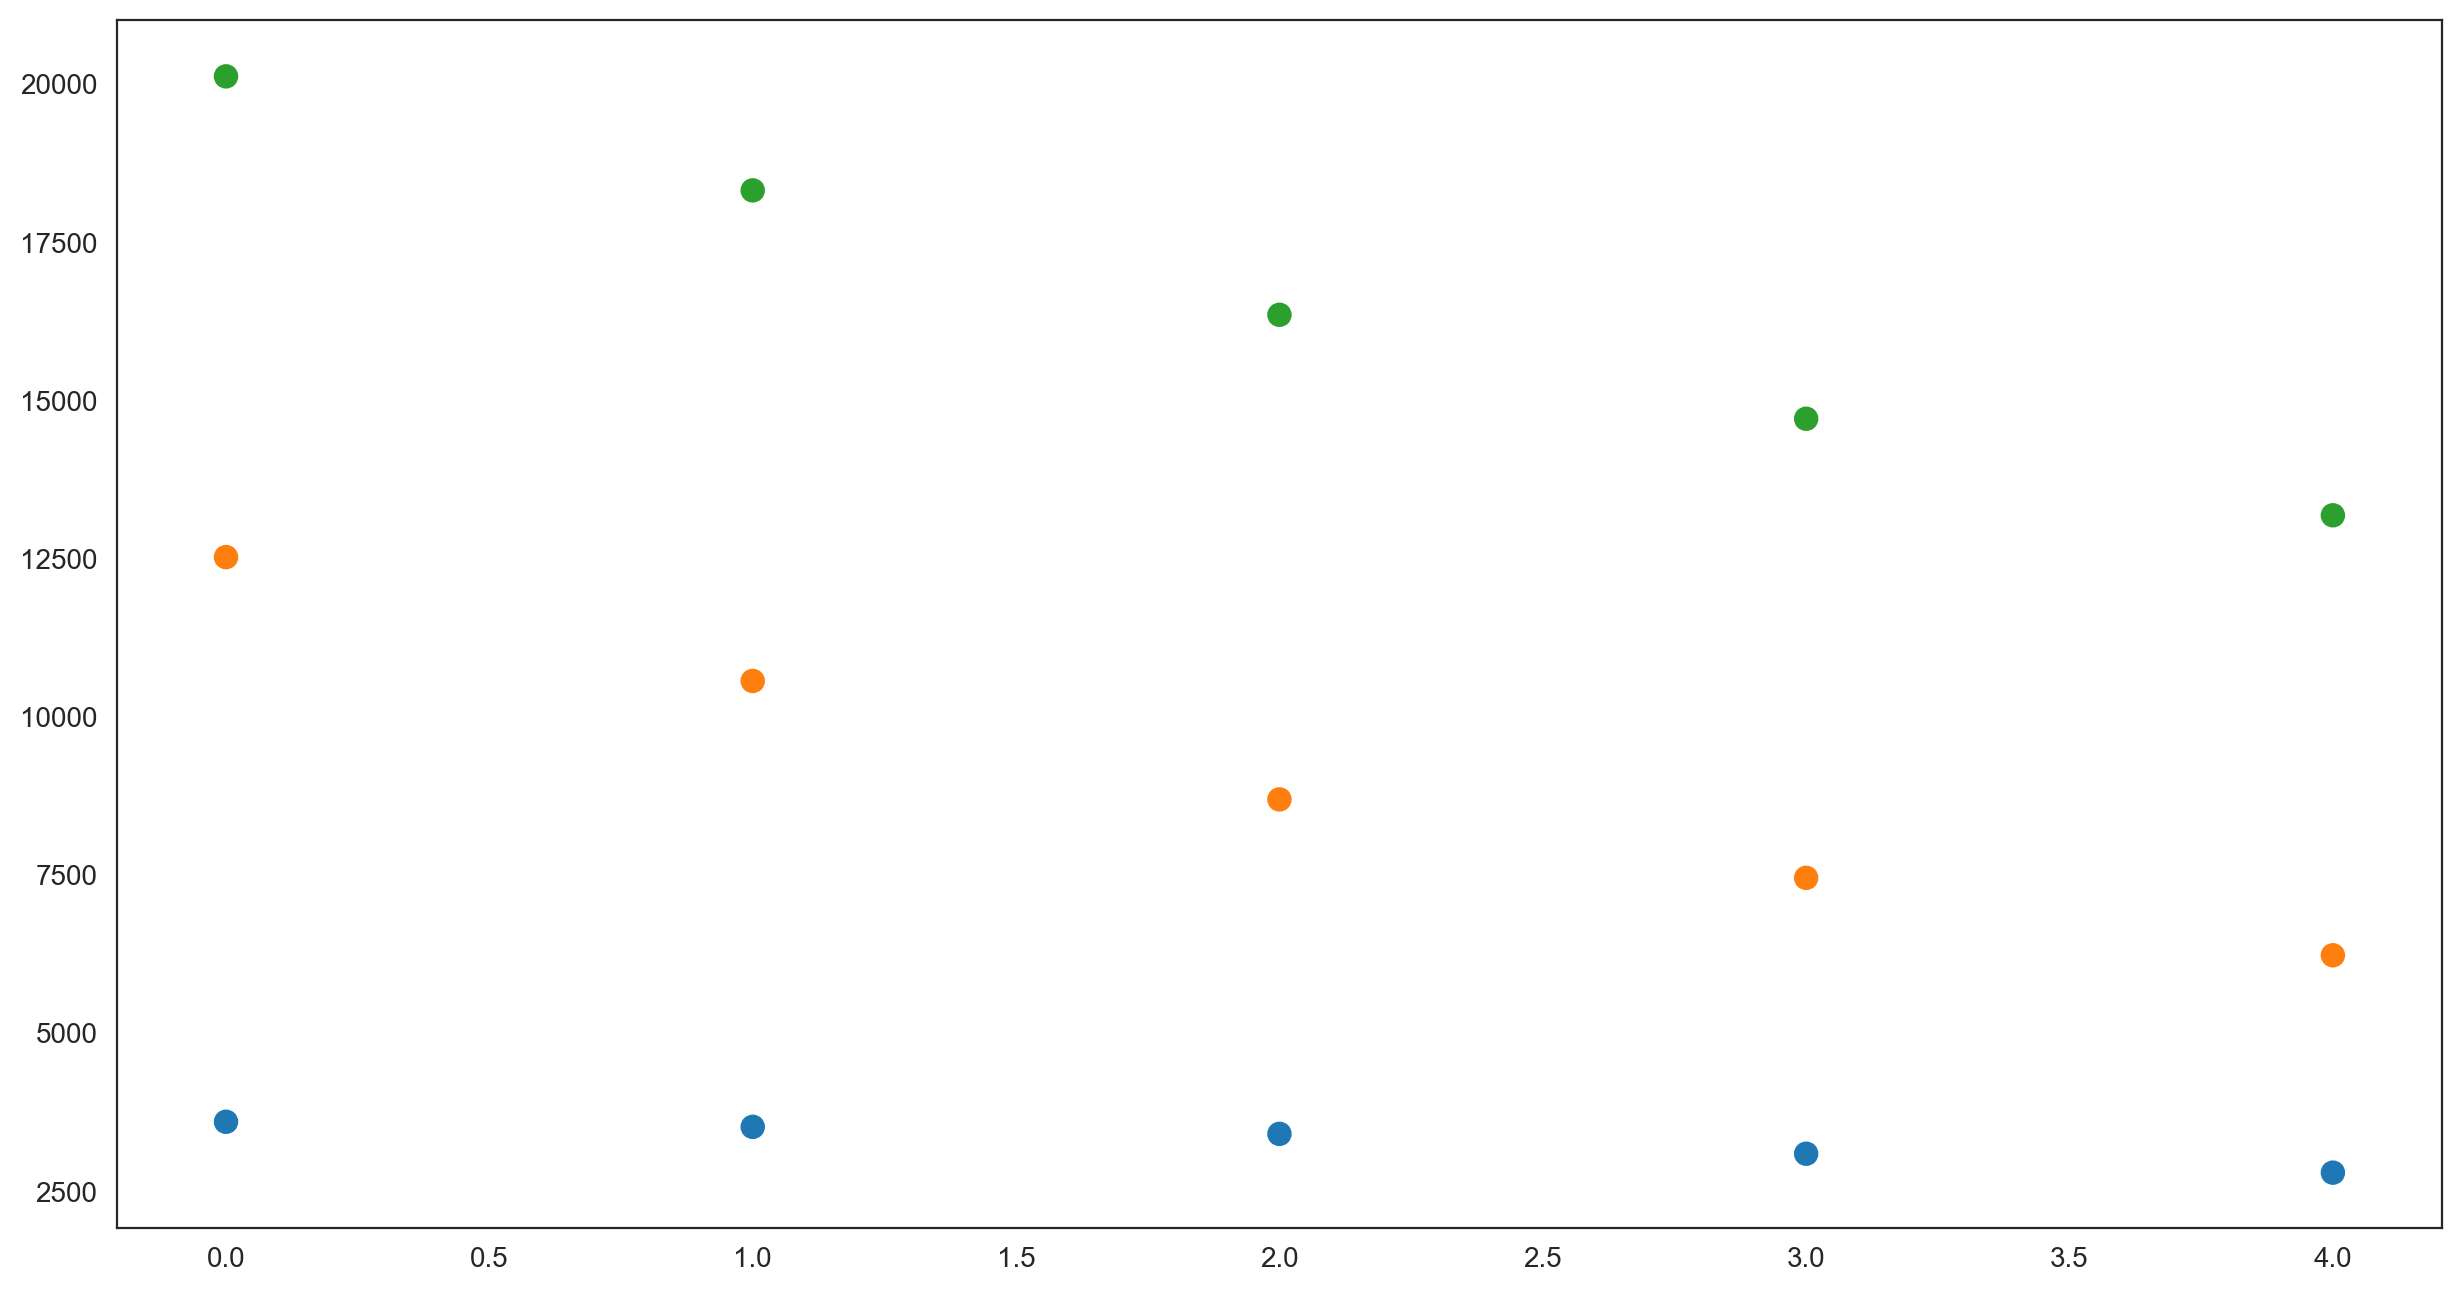

In [66]:
sns.set_style('white')
plt.figure(figsize=(15, 8), dpi=200)
sns.pointplot(x='add_to_cart_order', y='number_of_orders', 
        scale=1.00, join=False, data=x4, hue='department')


In [22]:
y = big['reordered']
X = big.drop('reordered', axis=1)
encode = OneHotEncoder()
X = encode.fit_transform(X)
y = to_categorical(y)

In [23]:
svd = TruncatedSVD(n_components=100).fit(X)
X = svd.fit_transform(X)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [25]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

In [26]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
model.fit(X_train, y_train,
         epochs=100,
         batch_size=128)
model.evaluate(X_test, y_test, batch_size=128)


Epoch 1/100
670000/670000 [==============================] - 43s 64us/step - loss: 0.5434 - accuracy: 0.7206
Epoch 2/100
670000/670000 [==============================] - 42s 62us/step - loss: 0.5322 - accuracy: 0.7271
Epoch 3/100
670000/670000 [==============================] - 43s 64us/step - loss: 0.5298 - accuracy: 0.7291
Epoch 4/100
670000/670000 [==============================] - 43s 64us/step - loss: 0.5283 - accuracy: 0.7300
Epoch 5/100
670000/670000 [==============================] - 42s 62us/step - loss: 0.5270 - accuracy: 0.7309
Epoch 6/100
670000/670000 [==============================] - 42s 62us/step - loss: 0.5259 - accuracy: 0.7316
Epoch 7/100
670000/670000 [==============================] - 42s 63us/step - loss: 0.5253 - accuracy: 0.7328
Epoch 8/100
670000/670000 [==============================] - 41s 61us/step - loss: 0.5247 - accuracy: 0.7327
Epoch 9/100
670000/670000 [==============================] - 42s 63us/step - loss: 0.5243 - accuracy: 0.7329
Epoch 10/100
67000

[0.5237124151952339, 0.7347576022148132]

In [29]:
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(optimizer='adam', neurons=64, dropout_rate=0.25):
    activation='relu'
    
    model = Sequential()
    model.add(BatchNormalization(axis=-1, momentum=.99, epsilon=.001, center=True, scale=True,
                                beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, batch_size=128, epochs=50)

In [31]:
from sklearn.model_selection import RandomizedSearchCV

params = {'neurons':[256,512],
         'dropout_rate':[0.25,0.5,0.75],
         'optimizer':['adam','sgd']}

grid = RandomizedSearchCV(estimator=model, param_distributions=params,
                         verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

C:\Users\nahum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 1145.1min finished


Epoch 1/50
670000/670000 [==============================] - 107s 160us/step - loss: 0.5561 - accuracy: 0.7123
Epoch 2/50
670000/670000 [==============================] - 44s 65us/step - loss: 0.5385 - accuracy: 0.7231
Epoch 3/50
670000/670000 [==============================] - 44s 65us/step - loss: 0.5365 - accuracy: 0.7244
Epoch 4/50
670000/670000 [==============================] - 45s 67us/step - loss: 0.5353 - accuracy: 0.7259
Epoch 5/50
670000/670000 [==============================] - 45s 68us/step - loss: 0.5347 - accuracy: 0.7260
Epoch 6/50
670000/670000 [==============================] - 45s 66us/step - loss: 0.5341 - accuracy: 0.7270
Epoch 7/50
670000/670000 [==============================] - 44s 66us/step - loss: 0.5341 - accuracy: 0.7270
Epoch 8/50
670000/670000 [==============================] - 44s 66us/step - loss: 0.5335 - accuracy: 0.7273
Epoch 9/50
670000/670000 [==============================] - 45s 66us/step - loss: 0.5332 - accuracy: 0.7267
Epoch 10/50
670000/670000 

{'optimizer': 'adam', 'neurons': 256, 'dropout_rate': 0.5}

In [28]:
fin_model = Sequential()
fin_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros'))
fin_model.add(Dense(256, activation='relu'))
fin_model.add(Dropout(0.5))
fin_model.add(Dense(256, activation='relu'))
fin_model.add(Dropout(0.5))
fin_model.add(Dense(256, activation='relu'))
fin_model.add(Dropout(0.5))
fin_model.add(Dense(2, activation='softmax'))

# compile the model
fin_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# fit the model
history = fin_model.fit(X_train, y_train,
       epochs=200,
       batch_size=256)
acc = history.history['accuracy']
plt.plot(acc)
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# evaluate the model
fin_model.evaluate(X_train, y_train, batch_size=256)

Epoch 1/200
670000/670000 [==============================] - 34s 51us/step - loss: 0.5441 - accuracy: 0.7193
Epoch 2/200
670000/670000 [==============================] - 34s 51us/step - loss: 0.5309 - accuracy: 0.7285
Epoch 3/200
670000/670000 [==============================] - 35s 52us/step - loss: 0.5280 - accuracy: 0.7306
Epoch 4/200
670000/670000 [==============================] - 38s 57us/step - loss: 0.5264 - accuracy: 0.7314
Epoch 5/200
670000/670000 [==============================] - 34s 50us/step - loss: 0.5250 - accuracy: 0.7329
Epoch 6/200
670000/670000 [==============================] - 40s 59us/step - loss: 0.5239 - accuracy: 0.7337
Epoch 7/200
670000/670000 [==============================] - 36s 54us/step - loss: 0.5233 - accuracy: 0.7338
Epoch 8/200
670000/670000 [==============================] - 44s 66us/step - loss: 0.5223 - accuracy: 0.7349
Epoch 9/200
670000/670000 [==============================] - 40s 60us/step - loss: 0.5216 - accuracy: 0.7353
Epoch 10/200
670000

670000/670000 [==============================] - 32s 47us/step - loss: 0.4954 - accuracy: 0.7529
Epoch 151/200
670000/670000 [==============================] - 30s 45us/step - loss: 0.4958 - accuracy: 0.7525
Epoch 152/200
670000/670000 [==============================] - 30s 45us/step - loss: 0.4959 - accuracy: 0.7530
Epoch 153/200
670000/670000 [==============================] - 31s 46us/step - loss: 0.4960 - accuracy: 0.7524
Epoch 154/200
670000/670000 [==============================] - 31s 46us/step - loss: 0.4957 - accuracy: 0.7529
Epoch 155/200
670000/670000 [==============================] - 32s 48us/step - loss: 0.4953 - accuracy: 0.7532
Epoch 156/200
670000/670000 [==============================] - 33s 49us/step - loss: 0.4953 - accuracy: 0.7529
Epoch 157/200
670000/670000 [==============================] - 34s 51us/step - loss: 0.4952 - accuracy: 0.7529
Epoch 158/200
670000/670000 [==============================] - 33s 49us/step - loss: 0.4959 - accuracy: 0.7526
Epoch 159/200
6

KeyError: 'acc'

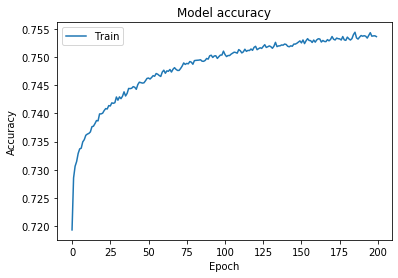

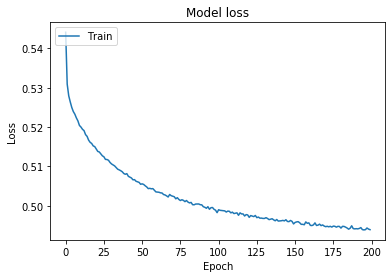

In [31]:
acc = history.history["accuracy"]
plt.plot(acc)
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


In [ ]:
# fit on test data
history = fin_model.fit(X_test, y_test,
       epochs=200,
       batch_size=256)

plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()

# evaluate the model
fin_model.evaluate(X_test, y_test, batch_size=256)

Epoch 1/200
330000/330000 [==============================] - 23s 71us/step - loss: 0.5309 - accuracy: 0.7281
Epoch 2/200
330000/330000 [==============================] - 18s 55us/step - loss: 0.5270 - accuracy: 0.7313
Epoch 3/200
330000/330000 [==============================] - 20s 59us/step - loss: 0.5249 - accuracy: 0.7324
Epoch 4/200
330000/330000 [==============================] - 19s 58us/step - loss: 0.5233 - accuracy: 0.7340
Epoch 5/200
330000/330000 [==============================] - 18s 54us/step - loss: 0.5217 - accuracy: 0.7350
Epoch 6/200
330000/330000 [==============================] - 16s 49us/step - loss: 0.5209 - accuracy: 0.7345
Epoch 7/200
330000/330000 [==============================] - 17s 52us/step - loss: 0.5195 - accuracy: 0.7359
Epoch 8/200
330000/330000 [==============================] - 17s 51us/step - loss: 0.5183 - accuracy: 0.7373
Epoch 9/200
330000/330000 [==============================] - 17s 51us/step - loss: 0.5175 - accuracy: 0.7378
Epoch 10/200
330000

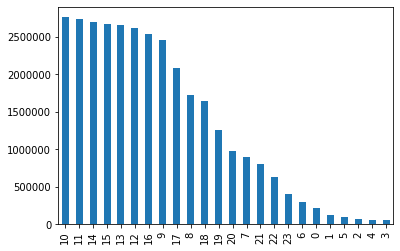

In [26]:
ax = big['order_hour_of_day'].value_counts().plot(kind='bar')
plt.show()

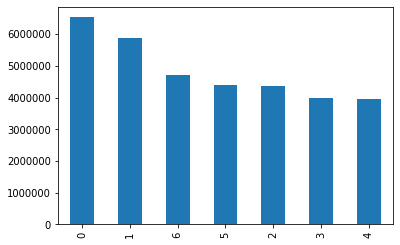

In [33]:
ax = big['order_dow'].value_counts().plot(kind='bar')
plt.show()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

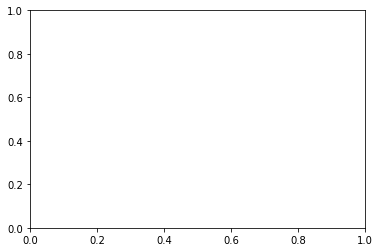

In [37]:
temp = big['department'].value_counts()
labels = np.array(temp.index)
sizes = np.array((temp / te))